# Exercise 1

Design a machine for protons at a total momentum of 20 GeV/c with the following basic parameters: 

- circumference = 1000 m,
- quadrupole length $L_{q}$ = 3.0 m,
- 8 FODO cells,
- dipole length is 5 m, maximum field is 3 T.

Apply the knowledge from previous lectures at this school and define a lattice cell according to the boundary conditions (position of dipole magnets and quadrupoles) and find the optics (strength of dipoles and quadrupoles) so that $\beta_{max}=\hat{\beta}$ is around 300 m. Implement 
it in MAD-X format using thin lenses for all elements and verify the calculations.

**DISCUSSION**: clearly we would like a periodic machine, that is we need to fill the full circumnfernce with FODO. The FODO lenght is therefore 125 m.

Let's start to consider the dipoles: how many dipoles do we need? I would say to have the same number of dipoles per cell. So we could consider a total of 8, 16, 24, 32 ... dipoles. Let's assume that all dipoles are identical,i.e., they give the same kick (angle $\alpha$) to the beam.
We have to remember that
\begin{equation}
\alpha = \frac{\int_{dipole} B_{dipole}dl}{B\rho}
\end{equation}
therefore 
\begin{equation}
\alpha_{MAX} < \frac{15~\rm{Tm}}{3.3356 \times 20~\rm{Tm}} \approx 0.22~\rm{rad}
\end{equation}

Since we have a circular machine, we need to have
\begin{equation}
\int_{C} d\alpha=2\pi
\end{equation}

So we need at least 29 dipoles. We chose the 32 dipoles for symmetry arguments (4 dipoles per cells).
Now that we defined the geometry of the machine (dipoles) we can focus on the quadrupoles.

We remember that

\begin{equation}
\beta_{MAX} = \frac{2 f_Q \sqrt{4f_Q+L_{cell}}}{{\sqrt{4f_Q-L_{cell}}}}
\end{equation}


In [109]:
import numpy as np
L = 125
def fun(f):
    return 2*f*np.sqrt(4*f+L)/np.sqrt(4*f-L)-300

import scipy

f_0=scipy.optimize.root(fun, 100)['x'][0]
f_0

112.88815320319954

In [55]:
# sanity check
fun(f_0)
# yes it is a root...

5.684341886080802e-14

Text(0, 0.5, '$\\beta_{MAX}$ [m]')

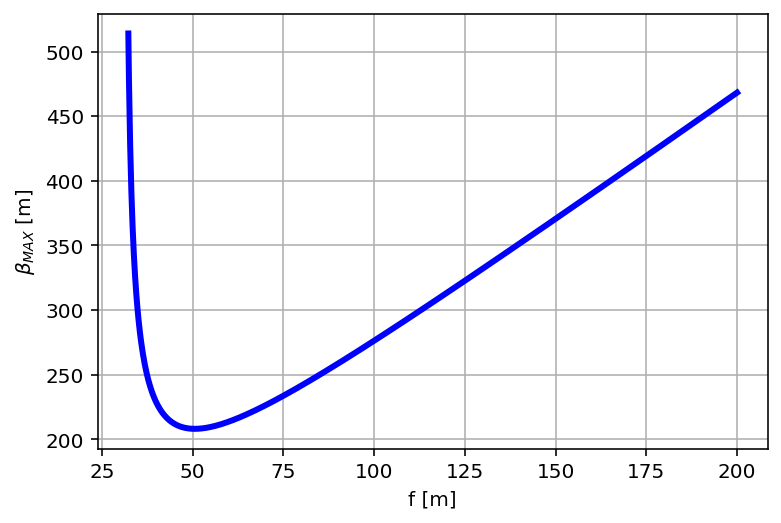

In [105]:
f = np.linspace(125/4+1,200, 1000)
plt.plot(f, fun(f)+300,'b',lw=3)
plt.grid(True)
plt.xlabel('f [m]')
plt.ylabel('$\\beta_{MAX}$ [m]')

In [106]:
# remembering k1*lq=1/f
lq=3
k1= 1/f_0/lq
k1

0.002952775148454548

In [95]:
from cpymad.madx import Madx
madx = Madx()
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib','inline')
%config InlineBackend.figure_format = 'retina' # retina display


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2022.11.09 12:15:43      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [96]:
ncell = 8
circ = 1000
lcell = circ/ncell
pc = 20

my_string = f'''
title, "CAS First Exercise"; 

circum= {circ};
ncell = {ncell}; !Number of cells 
lcell = {lcell};
lq = {lq}; !Length of a quadrupole

/***element definitions***/

!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole, knl = {{2.0*pi/(4*ncell)}};

!define quadrupoles as multipoles 
qf: multipole, knl={{0,{k1}*lq}}; 
qd: multipole, knl={{0,-{k1}*lq}};

!sequence declaration;
cas: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {{
    qf: qf, at=(n-1)*lcell;
    mb: mb, at=(n-1)*lcell+0.15*lcell;
    mb: mb, at=(n-1)*lcell+0.35*lcell;
    qd: qd, at=(n-1)*lcell+0.50*lcell;
    mb: mb, at=(n-1)*lcell+0.65*lcell;
    mb: mb, at=(n-1)*lcell+0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties

beam, particle = proton, pc = {pc};
use, sequence=cas;

!define the desired output
select,flag=twiss,column=name,s,x,y,mux,betx,alfx,muy,bety,alfy,dx,dy;
twiss;
'''
madx.input(my_string)

++++++ info: n redefined
++++++ info: at redefined
++++++ info: n redefined
++++++ info: at redefined
++++++ info: n redefined
++++++ info: at redefined
++++++ info: n redefined
++++++ info: at redefined
++++++ info: n redefined
++++++ info: at redefined
++++++ info: n redefined
++++++ info: at redefined
++++++ info: n redefined
++++++ info: at redefined
++++++ info: n redefined
enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
              1000                 -0        1.989278104       0.7090098174 

                q1                dq1            betxmax              dxmax 
      0.7142516844      -0.7343979649                300        365.0170902 

             dxrms             xcomax             xcorms                 q2 
       321.4862847                  

True

### The machine SURVEY

In [110]:
madx.input('survey') # or madx.survey()
mySurvey=madx.table.survey.dframe()

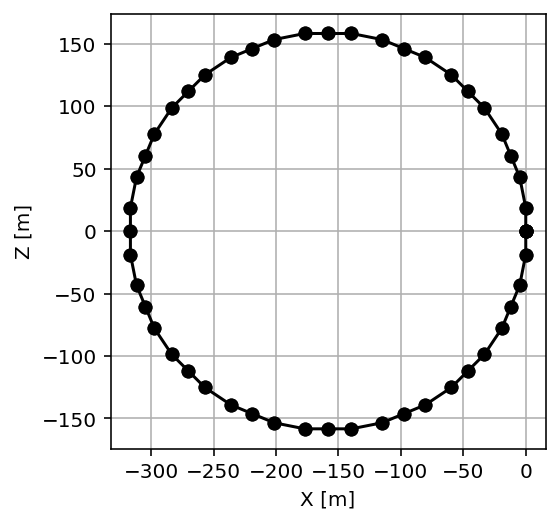

In [111]:
plt.plot(mySurvey.x,mySurvey.z,'o-k')
plt.axis('square');
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()

In [112]:
# Check the closure of the machine by comparting the coordinates of the machine's start and end.
display(mySurvey.head(1))
mySurvey.tail(1)

,name,keyword,s,l,angle,x,y,z,theta,phi,psi,globaltilt,tilt,slot_id,assembly_id,mech_sep,v_pos,comments
#s,cas$start:1,marker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,


,name,keyword,s,l,angle,x,y,z,theta,phi,psi,globaltilt,tilt,slot_id,assembly_id,mech_sep,v_pos,comments
#e,cas$end:1,marker,1000.0,0.0,0.0,-3.388886e-13,0.0,-8.171241e-14,-6.283185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,


### The machine TWISS

In [113]:
myTwiss=madx.table.twiss.dframe()

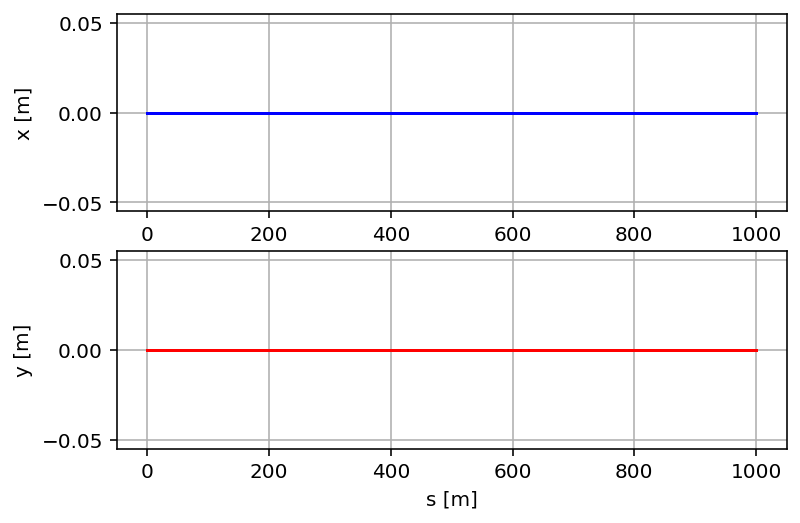

In [114]:
# The Closed orbit corresponds to the reference orbit
plt.subplot(211)
plt.plot(myTwiss.s,myTwiss.x,'b',label='x')
plt.ylabel('x [m]')
plt.grid()

plt.subplot(212)
plt.plot(myTwiss.s,myTwiss.y,'r',label='y')
plt.xlabel('s [m]')
plt.ylabel('y [m]')
plt.grid()

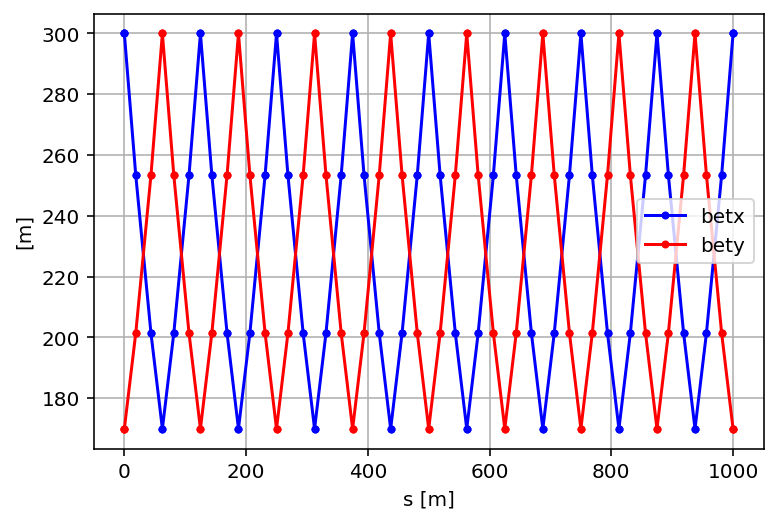

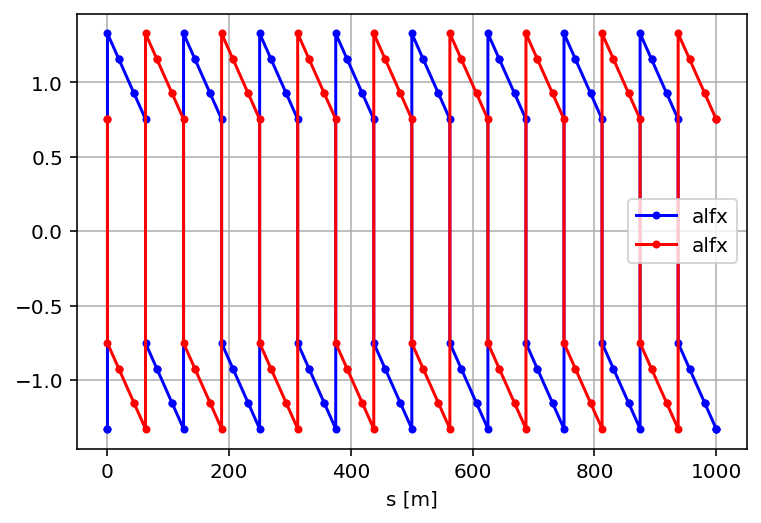

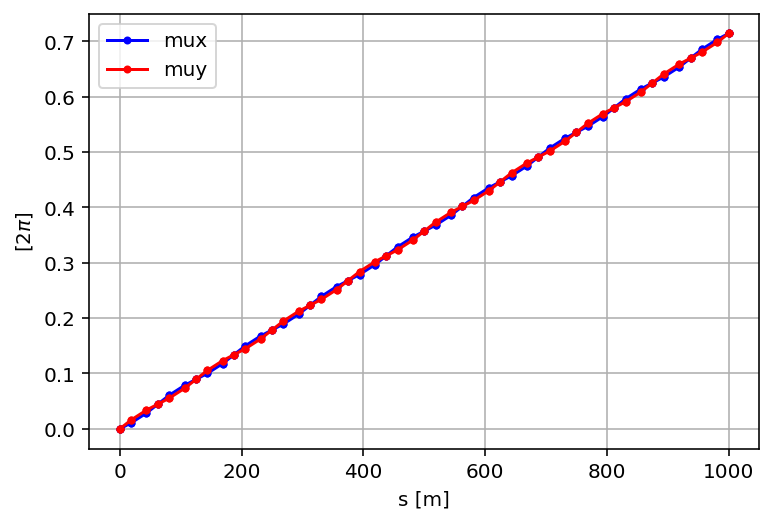

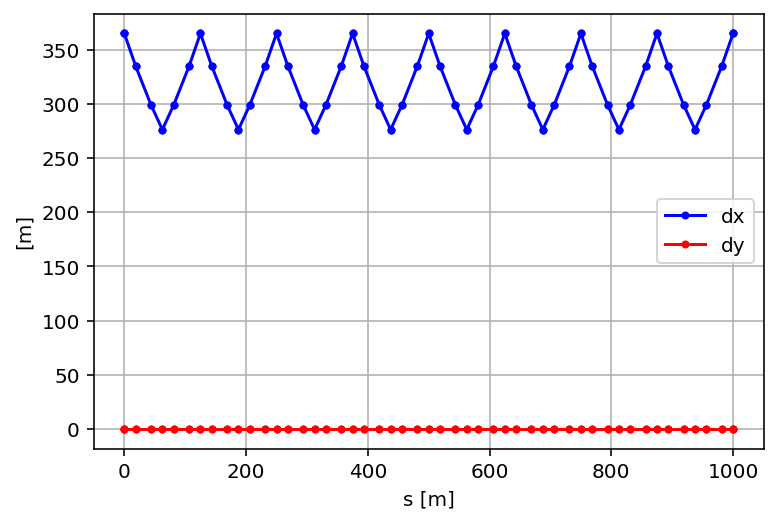

In [115]:
plt.plot(myTwiss.s,myTwiss.betx,'.-b', label='betx')
plt.plot(myTwiss.s,myTwiss.bety,'.-r', label='bety')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()
plt.legend()

plt.figure()
plt.plot(myTwiss.s,myTwiss.alfx,'.-b', label='alfx')
plt.plot(myTwiss.s,myTwiss.alfy,'.-r', label='alfx')
plt.xlabel('s [m]')
plt.ylabel('')
plt.grid()
plt.legend()

plt.figure()
plt.plot(myTwiss.s,myTwiss.mux,'.-b', label='mux')
plt.plot(myTwiss.s,myTwiss.muy,'.-r', label='muy')
plt.xlabel('s [m]')
plt.ylabel('[2$\pi$]')
plt.grid()
plt.legend()

plt.figure()
plt.plot(myTwiss.s,myTwiss.dx,'.-b', label='dx')
plt.plot(myTwiss.s,myTwiss.dy,'.-r', label='dy')
plt.xlabel('s [m]')
plt.ylabel('[m]')
plt.grid()
plt.legend()

In [120]:
assert madx.table.summ.q1[0]==madx.table.twiss.mux[-1]

0.714251684375606